In [1]:
import sys
sys.version

'3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
# Import stuff that we will use
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [3]:
# TF Version
tf.__version__

'1.1.0'

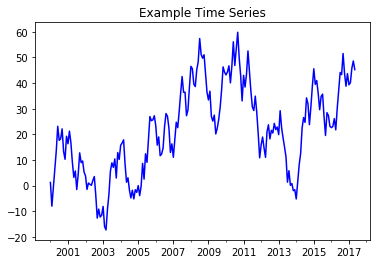

2000-01-31     1.201756
2000-02-29    -8.059026
2000-03-31    -0.965952
2000-04-30     6.243186
2000-05-31    13.527022
2000-06-30    23.129515
2000-07-31    17.653263
2000-08-31    18.260201
2000-09-30    22.119136
2000-10-31    13.347066
Freq: M, dtype: float64

In [4]:
# Generate a random TS
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10,10,size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
plt.gcf().clear()
ts.head(10)

In [5]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1 # forecast horizon

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1,20,1)
# -1 means that numpy will figure out that dimension's size dynamically

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+ f_horizon]
y_batches = y_data.reshape(-1,20,1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

10
(10, 20, 1)
[[[  1.20175592]
  [ -8.05902623]
  [ -0.96595223]
  [  6.24318628]
  [ 13.52702232]
  [ 23.12951495]
  [ 17.65326279]
  [ 18.26020144]
  [ 22.11913639]
  [ 13.34706557]
  [ 10.24244732]
  [ 19.23356407]
  [ 16.31360968]
  [ 21.23938156]
  [ 16.71175869]
  [  9.09595249]
  [  3.16208578]
  [  5.67858431]
  [ -1.56327251]
  [  4.45970193]]

 [[ 12.75593673]
  [  8.95773673]
  [  9.5778482 ]
  [  5.2320825 ]
  [  3.74189242]
  [ -1.52095932]
  [  0.98263196]
  [  0.47768733]
  [  0.09839409]
  [  1.97625588]
  [  3.52757701]
  [ -3.80669918]
  [-12.70704582]
  [ -9.19523832]
  [-12.28794208]
  [-11.61141992]
  [ -8.15615796]
  [-15.99151312]
  [-17.3224781 ]
  [ -9.13841643]]]
[[[ -8.05902623]
  [ -0.96595223]
  [  6.24318628]
  [ 13.52702232]
  [ 23.12951495]
  [ 17.65326279]
  [ 18.26020144]
  [ 22.11913639]
  [ 13.34706557]
  [ 10.24244732]
  [ 19.23356407]
  [ 16.31360968]
  [ 21.23938156]
  [ 16.71175869]
  [  9.09595249]
  [  3.16208578]
  [  5.67858431]
  [ -1.56327

In [6]:
def test_data(series, forecast, num_periods):
    test_x_setup = series[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = series[-(num_periods):].reshape(-1,20,1)
    return testX,testY
X_test, Y_test = test_data(TS,f_horizon,num_periods)
print(X_test.shape)
print(X_test)

(1, 20, 1)
[[[ 19.54369223]
  [ 28.44422456]
  [ 27.31613472]
  [ 23.12189929]
  [ 22.60749176]
  [ 23.06010139]
  [ 26.12685208]
  [ 21.73822059]
  [ 30.06672018]
  [ 37.090819  ]
  [ 44.1297821 ]
  [ 43.29436581]
  [ 51.54840076]
  [ 43.77129087]
  [ 38.77552484]
  [ 43.70593365]
  [ 39.33205157]
  [ 40.10947445]
  [ 45.81527662]
  [ 48.62989558]]]


In [7]:
tf.reset_default_graph()

inputs = 1 # number of vectors submitted
hidden = 100 # number of neurons we will recursively work through
output = 1 # number of output vectors

# create variable objects
X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu) #create a RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) 

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify dense layers
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # specify shape of results

loss = tf.reduce_sum(tf.square(outputs-y)) # define loss function
# if we are going to do a classification problem, this should be cross entropy
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent
training_op = optimizer.minimize(loss) # train according to the loss function

init = tf.global_variables_initializer() # init everything

In [8]:
def train_model(num_epochs = 1000):
    epochs = num_epochs # number of iterations or training cycles, includes both the FeedForward and backProp

    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
            # feed dict replaces placehoder with real numbers (well, tf.float32's, but you get the point)
            if ep % (epochs / 10) == 0:
                mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
                print(ep, "\tMSE:", mse)

        y_pred = sess.run(outputs, feed_dict={X: X_test})
        print(y_pred)
        return y_pred

In [9]:
one_k_pred = train_model()

0 	MSE: 167205.0
100 	MSE: 8495.15
200 	MSE: 3309.1
300 	MSE: 1455.19
400 	MSE: 940.468
500 	MSE: 785.325
600 	MSE: 757.691
700 	MSE: 744.621
800 	MSE: 663.269
900 	MSE: 641.061
[[[ 18.35085297]
  [ 28.67871857]
  [ 23.65476608]
  [ 22.95035744]
  [ 26.770504  ]
  [ 17.16387939]
  [ 27.33656693]
  [ 19.73564148]
  [ 32.83140945]
  [ 38.77821732]
  [ 42.32462692]
  [ 51.80494308]
  [ 54.34882355]
  [ 40.33844376]
  [ 37.51784515]
  [ 35.91236115]
  [ 47.28045273]
  [ 52.97082901]
  [ 54.89973068]
  [ 31.72385979]]]


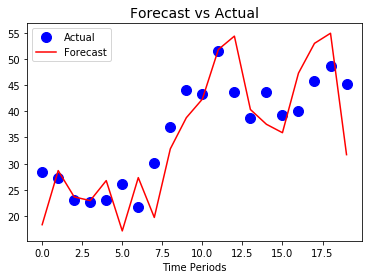

In [10]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(one_k_pred)), "r", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
plt.gcf().clear()

In [11]:
ten_k_pred = train_model(10000)

0 	MSE: 83936.1
1000 	MSE: 696.294
2000 	MSE: 1172.0
3000 	MSE: 255.689
4000 	MSE: 185.504
5000 	MSE: 151.557
6000 	MSE: 104.711
7000 	MSE: 81.7379
8000 	MSE: 76.6196
9000 	MSE: 73.923
[[[ 15.39670753]
  [ 23.11215401]
  [ 15.44321918]
  [ 27.62415504]
  [ 21.89763832]
  [ 16.23634911]
  [ 30.34317207]
  [ 17.19348335]
  [ 36.54111862]
  [ 34.11437607]
  [ 46.42856216]
  [ 46.40198135]
  [ 47.80204773]
  [ 41.19756699]
  [ 40.17473984]
  [ 46.57412338]
  [ 35.29389954]
  [ 41.55463791]
  [ 46.45732498]
  [ 49.22745895]]]


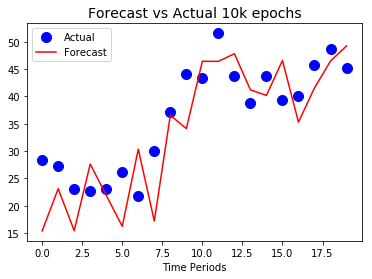

In [12]:
plt.title("Forecast vs Actual 10k epochs", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(ten_k_pred)), "r", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
plt.gcf().clear()